# Popping The Olin Bubble With A Hopper

Project 3

By Carlos Godinez and Pranavi Boyalakuntla 

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *
from math import floor
from IPython.display import Image

## Question

Cameron Balloons offers a special configuration of hot air balloons where the rider is strapped into a single occupancy suspension seat system called a “hopper”, a term that Olin students are all too familiar with. Additionally, many Olin students seem to have difficulty “popping” the Olin bubble and forget the importance of leaving our special little cult of ours every now and then. With this information in mind, we wanted to see what the maximum cross wind could be that would allow an Olin student to successfully and safely pop the Olin bubble in a hopper hot air balloon by avoiding hitting the Academic Center. 

## Method

Our model considers the hot air balloon moving as a point mass with multiple forces acting upon it. This is the buoyant force ($F_b$), wind force ($F_b$), drag force ($F_d$), and weight ($F_g$). Velocity ($\hat{v}$) is denoted as a vector resulting from the net force. 


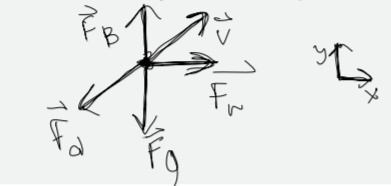

In [2]:
Image("SchematicProject3.png")

We chose to model our ballon using specifications from Cameron Balloon’s Z-77 model. This values are detailed in the system object. 

The movement of the hot air balloon is based on from the temperature of the hot air in the ballon. Temperature affects density, which affects buoyant force, which affects the acceleration of the ballon. We start the the ballon being neutrally buoyant so that any increase in temperature will start to begin to accelerate the ballon upwards.

The other forces on the ballon are drag, the cross wind, and weight of the ballon. An arbitrary number is chosen for wind speed for now until the answer to our question is calculated later.  Wind force is modeled to be a constant force. 

In [3]:
# Create units for model
m = UNITS.meter
s = UNITS.seconds
kg = UNITS.kilogram
degree = UNITS.degree
N = UNITS.newton
K = UNITS.kelvin
C = UNITS.celsius
F = UNITS.fahrenheit
W = UNITS.watt
J = UNITS.joule
Pa = UNITS.pascal

<Unit('pascal')>

The flight of the balloon is modelled in two stages, heating and cooling. During the heating phase the burner of the balloon is constantly on and during the cooling phase the burner is off and the balloon is allowed to cool. To model this we create two initial conditions and two systems. 


In [4]:
#Creates the inital state
T_0 =  385 * K # Starting temperature to be neutrally buoyant
x_0 = 0 *m
y_0 = 0 * m 
vx_0 = 0 * (m/s)
vy_0 = 0 * (m/s)

init = State(T=T_0,
            x=x_0,
            y=y_0,
            vx = vx_0,
            vy=vy_0)

,values
T,385 kelvin
x,0 meter
y,0 meter
vx,0 meter / second
vy,0 meter / second


In [5]:
#create system object for heating phase of flight
system1 = System(init = init,
                g = -9.8 * m/s**2,
                mass = 613 * kg,   #Mass of entire system including envelope, hopper system, fuel, passenger, and air inside ballon
                diameter = 15 * m,     #diameter of the hopper hot air balloon
                volume = 2200 * m**3,  #volume of hopper
                p_air = 1.2 * kg/m**3, #density (rho) of dry air
                coeff_d = 0.47,        #coefficient of drag
                area = 706.8 * m**2,   #cross sectional area of ballon for drag and wind force 
                gas_constant = 287.05 * J/(kg * K), #gas constant for pressure equation
                air_pressure = 101325 * Pa,       #constant air pressure 
                wind_speed = 25 , #wind speed for cross wind in m/s
                t_0 = 0 *s,             #start time of simulation
                t_end = 120 * s)        #end time of simulation

,values
init,T 385 kelvin x 0 meter ...
g,-9.8 meter / second ** 2
mass,613 kilogram
diameter,15 meter
volume,2200 meter ** 3
p_air,1.2 kilogram / meter ** 3
coeff_d,0.47
area,706.8 meter ** 2
gas_constant,287.05 joule / kelvin / kilogram
air_pressure,101325 pascal


We then create a function to model the change in density of air in the balloon based on the temperature. This was done using the equation $p_{air}=\frac{p}{RT}$, where $p_{air}$ is density of air, $p$ is air pressure, $R$ is gas constant, and $T$ is temperature. This model assumes a constant pressure within the balloon (101325 $Pa$).


In [6]:
def density_in(state, system):
    """Computes density of air inside ballon.
    
    state: State object with temperature, x and y postion, and x and y velocities
    system: System object 
    
    returns density of air in balloon in kg/m**3
    """
    unpack(system1)
    T, x, y, vx, vy = state
    density_in = air_pressure / (gas_constant * T)
    
    return density_in

In [7]:
#testing density function with inital state
density_in(init,system1)

<Quantity(0.9168500894681003, 'kilogram * pascal / joule')>

Using air density we can find the buoyant force on the balloon based on Archimedes Principle of Buoyancy. This is modeled with the equation $F_b=V(p_a - p_b)g$. $F_b$ is buoyant force, $V$ is volume of the ballon, $p_a$ is density of surrounding air, $p_b$ is density of air in balloon, and $g$ is acceleration due to gravity. Density of surrounding air is assumed to be constant (1.2$\frac{kg}{m^3}$). 

In [8]:
def buoyant_force(state, system):
    """Computes buoyant force.

    state: State object with temperature, x and y postion, and x and y velocities
    system: System object 
    
    returns buoyant force vector
    """
    T, x, y, vx, vy = state
    unpack(system1)
    
    d = Vector(0 * (m/s**2),-g) #create vector in opposite direction of gravity for upwards force
    
    balloon_density = density_in(state,system)
    f_b_mag = volume * (p_air - balloon_density) * d.mag
    direction = d.hat()
    f_b = direction * f_b_mag #multiple by magnitude to create force vector
    return f_b

In [9]:
#testing buoyancy function with inital state
buoyant_force(init, system1)

<Quantity([   0.         6104.71207107], 'kilogram * meter / second ** 2')>

Drag is then modeled using the equation $F_d=\frac{C_dp_{air}Av^2}{2}$. $F_d$ is drag force, $C_d$ is coefficient of drag, $p_{air}$ is density of surrounding air, $A$ is reference area, and $v$ is velocity of the balloon. The balloon was modeled to be a sphere with the coeffcient of drag assumed to be 0.47 and the reference area being the cross sectional area of the sphere ($706.8  m^2$).

In [10]:
def drag_force(state, system):
    """Computes drag force in the opposite direction of `V`.
    
    state: State object with temperature, x and y postion, and x and y velocities
    V: velocity vector
    system: System object
    
    returns: Vector drag force
    """
    T, x, y, vx, vy = state
    unpack(system1)
    V = Vector(vx, vy) #creates vector of velocity
    mag = p_air * V.mag**2 * coeff_d * area / 2
    direction = -V.hat() #direction of drag always opposes direction of velocity
    f_drag = direction * mag #mag multiplied by direction to get drag vector
    return f_drag

In [11]:
#testing drag function with inital state
drag_force(init,system1)

<Quantity([0. 0.], 'kilogram * meter / second ** 2')>

Wind force was then calculated based on a constant wind speed. To model this we used the equation $F_w=AW_pC_d$. $F_w$ is force of the wind, $A$ is reference area, $C_d$ is drag coefficient, and $W_p$ is wind pressure. $W_p$ is calculated from the equation $0.613v^2$ where $v$ is velocity of the wind in $m/s$. To remove dimensionality errors, units were removed from wind speed. The force of wind was modeled to only act in the x direction.

As stated before, the wind speed is chosen arbitrarily when first modeling the balloon and then later calculated to clear the AC.


In [12]:
def wind_force(state, system):
    """Computes force of cross wind based on wind speed
    
    state: State object with temperature, x and y postion, and x and y velocities
    system: System object
    

    returns: wind force vector
    """
    
    T, x, y, vx, vy = state
    unpack(system1)
    direction = Vector(1,0) #vector acting only in x direction
    wind_pressure = (wind_speed**2) * 0.613 * (N/(m**2))
    mag = area * coeff_d * 0.613 * wind_pressure
    wind_force = direction * mag #creates wind force vector
    
    return wind_force

In [13]:
#testing wind force function with inital state
wind_force(init,system1)

<Quantity([78018.0992025     0.       ], 'newton')>

All of the previous functions are then passed along into the slop function. The slope function calculates derivatives of the state to then be used in run_ode_solver. 

To model the change in temperature in the ballon, we used Adriana Gambín’s conclusions from their technical paper on the performance in hot air balloons that there is a net increase in temperature of 1 degree K for every second of burner activity and a loss of 0.256 degree K per second when the burner is off. For the first phase we model the burner on for the entire 2 minute duration.


In [14]:
def slope_func_heat(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: derivatives of state
    """
    T, x, y, vx, vy = state
    unpack(system1)
    
    
    dTdt = 1 #change in temperature for 1 second of burner activity
    V = Vector(vx, vy)  
    a_buoyant = buoyant_force(state, system) / mass #buoyancy vector divided by mass to get acceleration from force
    a_wind = wind_force(state,system) / mass #wind vector divided by mass to get acceleration from force
    a_drag = drag_force(state, system) / mass #drag vector divided by mass to get acceleration from force
    a_grav = Vector(0, g) #gravity vector divided by mass to get acceleration from force
    
    a = a_grav + a_drag + a_wind + a_buoyant #adding all accelerations to get net acceleration
   
        
    return dTdt, vx, vy, a.x, a.y

In [15]:
#testing slope func for heating
slope_func_heat(init, 0, system1)

(1,
 <Quantity(0, 'meter / second')>,
 <Quantity(0, 'meter / second')>,
 <Quantity(127.2725925, 'meter / second ** 2')>,
 <Quantity(0.1587472611219507, 'meter / second ** 2')>)

## Results 1

We use run_ode_solver to obtain the results of the first phase of the simualtion where the burner is on for 2 minutes straight. We then plot the Y distance over time and the trajectory of the balloon. 

In [16]:
#running run_ode_solver with time step of 1 second 
ts = linrange(system1.t_0/s, system1.t_end/s, 1)
results_heat, details = run_ode_solver(system1, slope_func_heat, t_eval = ts)

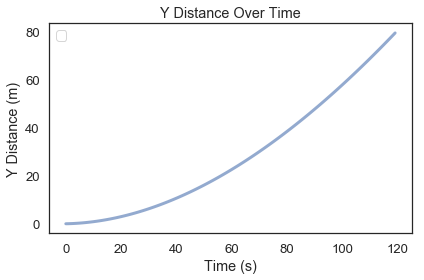

In [17]:
results_heat.tail()
plot(results_heat.y)
decorate(title="Y Distance Over Time",
        xlabel = "Time (s)",
        ylabel = "Y Distance (m)")

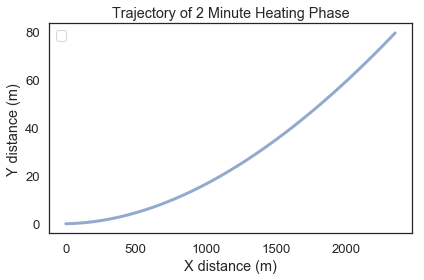

In [18]:
plot(results_heat.x, results_heat.y)
decorate(title = "Trajectory of 2 Minute Heating Phase",
        xlabel = "X distance (m)",
        ylabel = "Y distance (m)")

## Method 2

To begin the second phase of the model where the temperature inside the balloon is cooling off we create a new init and system object by grabbing the results from the first phase. 

In [19]:
t_0 = get_last_label(results_heat) * s
T, x, y, vx, vy = get_last_value(results_heat)
init2 = State(T=T*K, x=x*m, y=y*m, vx=vx*m/s, vy=vy*m/s)

,values
T,503.99999999999727 kelvin
x,2351.389860202032 meter
y,79.44025529795056 meter
vx,19.7568188031536 meter / second
vy,1.2053759083223126 meter / second


In [20]:
system2 = System(system1, t_0=t_0, init=init2, t_end= 5000 *s)

,values
init,T 503.99999999999727 kelvin x ...
g,-9.8 meter / second ** 2
mass,613 kilogram
diameter,15 meter
volume,2200 meter ** 3
p_air,1.2 kilogram / meter ** 3
coeff_d,0.47
area,706.8 meter ** 2
gas_constant,287.05 joule / kelvin / kilogram
air_pressure,101325 pascal


A new slope function to model the temperature cooling is then created. The temperature cools 0.256 degrees K for every second according to Gambín’s paper.

In [21]:
def slope_func_cool(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: derivatives of state
    """
    T, x, y, vx, vy = state
    unpack(system2)
    
    
    dTdt = -0.256 #change in temperature for 1 second of no burner activity
    V = Vector(vx, vy)  
    a_buoyant = buoyant_force(state, system) / mass #buoyancy vector divided by mass to get acceleration from force
    a_wind = wind_force(state,system) / mass #wind vector divided by mass to get acceleration from force
    a_drag = drag_force(state, system) / mass #drag vector divided by mass to get acceleration from force
    a_grav = Vector(0, g) #gravity vector divided by mass to get acceleration from force
    
    a = a_grav + a_drag + a_wind + a_buoyant #all acceleration vectors added together for net acceleration

    return dTdt, vx, vy, a.x, a.y

In [22]:
#testing slope function for phase 2
slope_func_cool(init, 0, system2)

(-0.256,
 <Quantity(0, 'meter / second')>,
 <Quantity(0, 'meter / second')>,
 <Quantity(127.2725925, 'meter / second ** 2')>,
 <Quantity(0.1587472611219507, 'meter / second ** 2')>)

We then create an event function to stop run_ode_solver when the balloon hits the ground. 

In [23]:
def event_func(state, t, system):
    """Stops ode_solver when balloon hits ground
    """
    T, x, y, vx, vy = state
    return y

## Results 2

We then use run_ode_solver with our cooling slope function, new system, and new inital conditions to obtain the final results. The Y distance over time and trajectory are then plotted. 

In [24]:
#running run_ode_solver with time step of 1 second 
ts = linrange(system2.t_0/s, system2.t_end/s, 1)
results_cool, details = run_ode_solver(system2, slope_func_cool, t_eval = ts, events=event_func)
results_cool.tail()

,T,x,y,vx,vy
1019.0,273.600,20148.061984,8.455731,19.740315,-2.010813
1020.0,273.344,20167.795480,6.442320,19.738940,-2.017262
1021.0,273.088,20187.528844,4.422330,19.734960,-2.023456
1022.0,272.832,20207.261992,2.395756,19.729397,-2.029496
1023.0,272.576,20226.994841,0.362595,19.723329,-2.035492


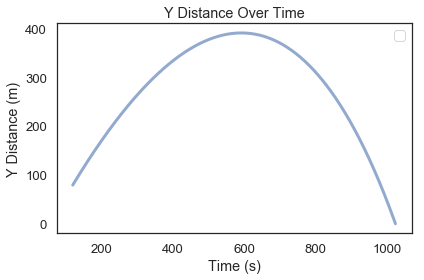

In [25]:
plot(results_cool.y)
decorate(title = "Y Distance Over Time",
        xlabel = "Time (s)",
        ylabel = "Y Distance (m)")

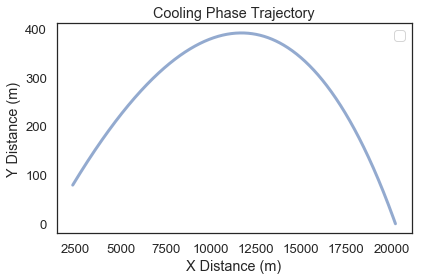

In [32]:
plot(results_cool.x, results_cool.y)
decorate(title = "Cooling Phase Trajectory",
        xlabel = "X Distance (m)",
        ylabel = "Y Distance (m)")

We then take the results from both phases of the simulation and combine them and plot this trajectory. 

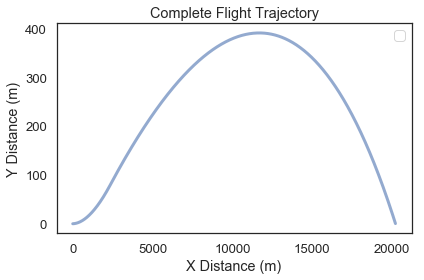

In [33]:
results = results_cool.combine_first(results_heat)
plot(results.x, results.y)
decorate(title = "Complete Flight Trajectory",
        xlabel = "X Distance (m)",
        ylabel = "Y Distance (m)")


## Method 3

We now can calculate the maximum windspeed a hot air balloon launching from the “O” can experience without hitting the AC. We create an event function that stop the first phase of the simulation after the balloon has travelled 28 meters in the x direction. This is the distance from the center of the “O” to the closest building. If the balloon can ascend fast enough to clear the AC then it does not matter which direction the wind comes from since all other building are further away. 


In [27]:
def AC_event_func(state, t, system):
    """Event function that stops the simulation after traveling 28 meters in the x direction
    """
    T, x, y, vx, vy = state
    return x - 28

Next we create a height function that calculates the height the balloon will reach with various wind speeds after traveling 28 meters.

In [28]:
def height_func(wind_speed, system):
    """Computes the height of the ballon when it reaches the AC.
    
    wind_speed: wind speed in m/s
    system: System object
    
    returns: height in meters
    """    
    system.wind_speed = wind_speed
    results, details = run_ode_solver(system, slope_func_heat, events=AC_event_func)
    height = get_last_value(results.y)
    
    return height

In [34]:
#testing height function
height_func(1.5, system1)

94.72633813776339

Lastly we create an error function to calculate the difference in height from the height function and the height needed to clear the AC (18.9 meters). 

In [30]:
def error_func(wind_speed, system):
    """Returns the height at the AC minus the target height.
    
    velocity: initial velocity in m/s
    params: Params object
    
    returns: height difference in meters
    """    
    system.wind_speed = wind_speed
    height = height_func(wind_speed,system)
    return abs(18.9 - height)

## Results 3

To find the final answer to our question, we use min_bounded to minimize the error function and find that the largest wind speed that a balloon launching from the "O" is 2.37 meters per second (5.03 miles per hour).

In [35]:
min_bounded(error_func, [0,4.4], system1)

,values
fun,0.00349407
status,0
success,True
message,Solution found.
x,2.37686
nfev,17


## Interpretation

Our model gives a reasonable output that makes sense. It is sensible that cross winds would have such a large effect on hot air balloons as they have such a large area to act upon and are not very aerodynamic. This leads to even the smallest breeze to have a large effect on the balloon. Our output of the maximum speed being just over 5 miles per hour seems very realistic seeing that ideal wind speed conditions to fly hot air balloons are in the 4-6 miles per hour range with the upper limits of what is safe being 8-10 miles per hour. 


Our model does make some assumptions that could potentially have large effects on the performance, most prominently being the assumption of constant air pressure inside of the balloon. Future models could include this to have a more accurate model. Additionally, hot air balloon burners are not capable of being on for 2 minutes straight. For our model of wanting to ascend above the AC as fast as possible, it is feasible for a modern burner to be capable of a straight burn to ascend 18.9 meters, but past this would likely lead to damage to the balloon/and or burner. A future iteration could include on and off cycling of the burner during both ascending and descending so the balloon does not end with a free fall into the ground.


Iterations of this model began with a simple two force model of just buoyancy and weight and then led to new interactions including drag and cross winds. 